<a href="https://colab.research.google.com/github/Rohit1217/MADE/blob/main/made.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import matplotlib.pyplot as plt
import numpy as np

import torch,torchvision
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms


In [13]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)

data_target=data*0.5+0.5
data_target
data=data.view(60000,784)
data=data.to(dtype=torch.float32)
data_target=data_target.view(60000,784)
#new_column = torch.full((60000, 1), 0)
#data = torch.cat((new_column, data[:, :-1]), dim=1)

trainset=TensorDataset(data,data_target)
trainloader=DataLoader(trainset,batch_size=256,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 108208932.05it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9578215.69it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30414228.40it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5132146.76it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [3]:
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False)
data_t=testset.data
data_t=data_t.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data_t=norm(data_t)
data_t=data_t.view(10000,784)
new_column = torch.full((10000, 1), 2)
data_t = torch.cat((new_column, data_t[:, :-1]), dim=1)

In [4]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def masker(mask):
  out,inn=mask.shape
  stride=inn/out
  for i in range(out):

    for j in range(inn):
      if j>=(i)*stride:
        mask[i,j]=0
  return mask
x=torch.ones(5,5)
masker(x)

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]])

In [6]:
def mask(inn,out):
  mask=torch.ones(out,inn)
  return masker(mask)
#mask(5,5)

In [7]:
class MaskedLinear(nn.Module):
  def __init__(self,in_dim,out_dim):
    super(MaskedLinear,self).__init__()
    self.fc=nn.Linear(in_dim,out_dim)
    self.mask1=mask(in_dim,out_dim).to(get_device())
    self.register_buffer('mask',self.mask1)

  def forward(self,x):
    self.fc.weight.data*=self.mask
    return self.fc(x)


In [8]:
class Made(nn.Module):
  def __init__(self,latent_dim):
    super(Made,self).__init__()
    self.ldim=latent_dim
    self.fc1=MaskedLinear(784,latent_dim)
    self.ln1=nn.LayerNorm(latent_dim)
    self.fc2=MaskedLinear(latent_dim,784)
    self.fc3=MaskedLinear(784,784)
    self.fc4=MaskedLinear(784,784)
    self.fc5=MaskedLinear(784,784)

  def forward(self,x):
    #x=x+torch.arange(784).to(get_device())
    x=(F.relu(self.fc1(x)))
    x=(F.relu(self.fc2(x)))
    x=(F.relu(self.fc3(x)))
    x=F.relu(self.fc4(x))
    x=self.fc5(x)
    return x

In [ ]:
lr_rate=0.001
epochs=100
model=Made(784)
model.to(get_device())
criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=lr_rate)

In [ ]:
loss_list=[]
for epoch in range(epochs):
  total_loss=0
  length=0
  avg_nats_dim=0
  epsilon=0.0001
  for input,target in trainloader:
    B,C=input.shape
    input,target=input.to(get_device()),target.to(get_device())
    pred=F.sigmoid(model(input))
    loss=criterion(pred,target)

    avg_nats_dim+=

    total_loss+=loss.item()
    length+=1
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'total_loss ={total_loss},avg_loss={total_loss/length},epoch={epoch},avg_nats/dim={avg_nats_dim/(784*length)}')

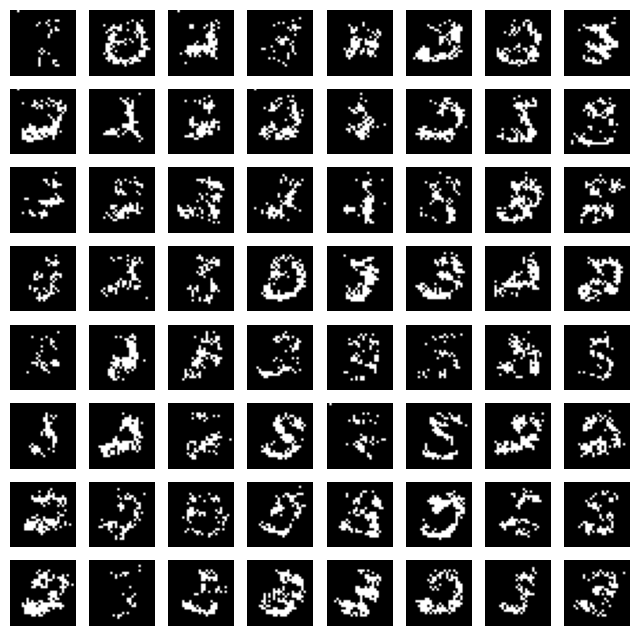

In [41]:
x = torch.zeros(64,784)
x=x.to(get_device())
y=x
x=2*x-1

with torch.no_grad():
    for i in range(783):
            out =(model(x))
            probs = F.sigmoid(out[:,i]).data
            x[:,i+1] = (torch.bernoulli(probs).float()).view(64)
            x[:,i+1]=2*x[:,i+1]-1

x=0.5*(x+1)
x[:,0]=0
x = x[:64].view(8, 8, 28, 28)
x = x.detach().to('cpu')
image_np = x.numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels

plt.savefig("sample.jpeg")
plt.show()

In [30]:
model

Made(
  (fc1): MaskedLinear(
    (fc): Linear(in_features=784, out_features=784, bias=True)
  )
  (ln1): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
  (fc2): MaskedLinear(
    (fc): Linear(in_features=784, out_features=784, bias=True)
  )
  (ln2): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
  (fc3): MaskedLinear(
    (fc): Linear(in_features=784, out_features=784, bias=True)
  )
  (fc4): MaskedLinear(
    (fc): Linear(in_features=784, out_features=784, bias=True)
  )
  (fc5): MaskedLinear(
    (fc): Linear(in_features=784, out_features=784, bias=True)
  )
)